In [1]:
import pandas as pd
import numpy as np
from lightgbm.sklearn import LGBMClassifier
from sklearn.metrics import accuracy_score, auc, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.model_selection import KFold
## 0. 打印设置
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)  ## 显示全部结果，不带省略点
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:.2f}'.format)
import pandas as pd
from matplotlib import  pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
import xgboost
%matplotlib inline

In [2]:
# 1. 概况分析
# 1.1 读取数据
x_train = pd.read_csv(r'./data/train.csv')
x_test = pd.read_csv(r'./data/test.csv')

In [6]:
# 1.2 概况预览
def overViewAnalysis1(dataframe):
    print('----------------整体概况----------------')
    overview = pd.DataFrame()
    overview['type'] = dataframe.dtypes
    overview['row_nums'] = dataframe.shape[0]
    overview['null_nums'] = dataframe.isnull().sum()
    #overview['min_num'] = dataframe.min()
    #overview['max_num'] = dataframe.max()
    overview['mean_num'] = dataframe.describe().loc['mean']
#     overview['std_num'] = dataframe.describe().loc['std']

    for col in dataframe.columns:
        overview.loc[col,'nunique_nums'] = dataframe[col].nunique()

    print(overview)
    print('----------------整体概况----------------')

In [7]:
overViewAnalysis1(x_train)

----------------整体概况----------------
                                type  row_nums  null_nums   mean_num  nunique_nums
policy_id                      int64       700          0  549624.98        700.00
age                            int64       700          0      38.65         45.00
customer_months                int64       700          0     205.30        332.00
policy_bind_date              object       700          0        NaN        674.00
policy_state                  object       700          0        NaN          3.00
policy_csl                    object       700          0        NaN          3.00
policy_deductable              int64       700          0    1147.86          3.00
policy_annual_premium        float64       700          0    1246.55        698.00
umbrella_limit                 int64       700          0 1100000.00         11.00
insured_zip                    int64       700          0  502796.82        699.00
insured_sex                   object       700    

In [5]:
## 2. 数据EDA探索
## 2.1 数据清洗
# 0） 空值处理，不需要
# 1) 日期转换,加入后，得分下降
# policy_bind_date, incident_date
# for data in x_train,x_test:
#     data['policy_bind_date'] = pd.to_datetime(data['policy_bind_date'])
#     data['incident_date'] = pd.to_datetime(data['incident_date'])

#     base_date = data['policy_bind_date'].min()

#     # 转换为date_diff
#     data['policy_bind_date_diff'] = (data['policy_bind_date'] - base_date).dt.days
#     data['incident_date_diff'] = (data['incident_date'] - base_date).dt.days

#     #去掉原始日期字段 policy_bind_date    incident_date
#     data.drop(['policy_bind_date', 'incident_date'], axis=1, inplace=True)

In [28]:
# 3） 均值编码

class MeanEncoder:
    def __init__(self, categorical_features, n_splits=5, target_type='classification', prior_weight_func=None):
        """
        :param categorical_features: list of str, the name of the categorical columns to encode

        :param n_splits: the number of splits used in mean encoding

        :param target_type: str, 'regression' or 'classification'

        :param prior_weight_func:
        a function that takes in the number of observations, and outputs prior weight
        when a dict is passed, the default exponential decay function will be used:
        k: the number of observations needed for the posterior to be weighted equally as the prior
        f: larger f --> smaller slope
        """

        self.categorical_features = categorical_features
        self.n_splits = n_splits
        self.learned_stats = {}

        if target_type == 'classification':
            self.target_type = target_type
            self.target_values = []
        else:
            self.target_type = 'regression'
            self.target_values = None

        if isinstance(prior_weight_func, dict):
            self.prior_weight_func = eval('lambda x: 1 / (1 + np.exp((x - k) / f))', dict(prior_weight_func, np=np))
        elif callable(prior_weight_func):
            self.prior_weight_func = prior_weight_func
        else:
            self.prior_weight_func = lambda x: 1 / (1 + np.exp((x - 2) / 1))

    @staticmethod
    def mean_encode_subroutine(X_train, y_train, X_test, variable, target, prior_weight_func):
        X_train = X_train[[variable]].copy()
        X_test = X_test[[variable]].copy()

        if target is not None:
            nf_name = '{}_pred_{}'.format(variable, target)
            X_train['pred_temp'] = (y_train == target).astype(int)  # classification
        else:
            nf_name = '{}_pred'.format(variable)
            X_train['pred_temp'] = y_train  # regression
        prior = X_train['pred_temp'].mean()

        col_avg_y = X_train.groupby(by=variable, axis=0)['pred_temp'].agg([('mean', 'mean'), ('beta', 'size')])
        col_avg_y['beta'] = prior_weight_func(col_avg_y['beta'])
        col_avg_y[nf_name] = col_avg_y['beta'] * prior + (1 - col_avg_y['beta']) * col_avg_y['mean']
        col_avg_y.drop(['beta', 'mean'], axis=1, inplace=True)

        nf_train = X_train.join(col_avg_y, on=variable)[nf_name].values
        nf_test = X_test.join(col_avg_y, on=variable).fillna(prior, inplace=False)[nf_name].values

        return nf_train, nf_test, prior, col_avg_y

    def fit_transform(self, X, y):
        """
        :param X: pandas DataFrame, n_samples * n_features
        :param y: pandas Series or numpy array, n_samples
        :return X_new: the transformed pandas DataFrame containing mean-encoded categorical features
        """
        X_new = X.copy()
        if self.target_type == 'classification':
            skf = StratifiedKFold(self.n_splits)
            skf = KFold(self.n_splits)

        if self.target_type == 'classification':
            self.target_values = sorted(set(y))
            self.learned_stats = {'{}_pred_{}'.format(variable, target): [] for variable, target in product(self.categorical_features, self.target_values)}
            for variable, target in product(self.categorical_features, self.target_values):
                nf_name = '{}_pred_{}'.format(variable, target)
                X_new.loc[:, nf_name] = np.nan
                for large_ind, small_ind in skf.split(y, y):
                    nf_large, nf_small, prior, col_avg_y = MeanEncoder.mean_encode_subroutine(
                        X_new.iloc[large_ind], y.iloc[large_ind], X_new.iloc[small_ind], variable, target, self.prior_weight_func)
                    X_new.iloc[small_ind, -1] = nf_small
                    self.learned_stats[nf_name].append((prior, col_avg_y))
        else:
            self.learned_stats = {'{}_pred'.format(variable): [] for variable in self.categorical_features}
            for variable in self.categorical_features:
                nf_name = '{}_pred'.format(variable)
                X_new.loc[:, nf_name] = np.nan
                for large_ind, small_ind in skf.split(y, y):
                    nf_large, nf_small, prior, col_avg_y = MeanEncoder.mean_encode_subroutine(
                        X_new.iloc[large_ind], y.iloc[large_ind], X_new.iloc[small_ind], variable, None, self.prior_weight_func)
                    X_new.iloc[small_ind, -1] = nf_small
                    self.learned_stats[nf_name].append((prior, col_avg_y))
        return X_new

    def transform(self, X):
        """
        :param X: pandas DataFrame, n_samples * n_features
        :return X_new: the transformed pandas DataFrame containing mean-encoded categorical features
        """
        X_new = X.copy()

        if self.target_type == 'classification':
            for variable, target in product(self.categorical_features, self.target_values):
                nf_name = '{}_pred_{}'.format(variable, target)
                X_new[nf_name] = 0
                for prior, col_avg_y in self.learned_stats[nf_name]:
                    X_new[nf_name] += X_new[[variable]].join(col_avg_y, on=variable).fillna(prior, inplace=False)[
                        nf_name]
                X_new[nf_name] /= self.n_splits
        else:
            for variable in self.categorical_features:
                nf_name = '{}_pred'.format(variable)
                X_new[nf_name] = 0
                for prior, col_avg_y in self.learned_stats[nf_name]:
                    X_new[nf_name] += X_new[[variable]].join(col_avg_y, on=variable).fillna(prior, inplace=False)[
                        nf_name]
                X_new[nf_name] /= self.n_splits

        return X_new

In [ ]:
# 3） 

In [6]:
# 2） 数据编码
Ca_feature = list(x_train.select_dtypes(include=['object']).columns)
lb = LabelEncoder()
for col in Ca_feature:
    x_train[col] = lb.fit_transform(x_train[col])
    x_test[col] = lb.fit_transform(x_test[col])
overViewAnalysis1(x_train)

----------------整体概况----------------
                                type  row_nums  null_nums     min_num     max_num   mean_num  nunique_nums
policy_id                      int64       700          0    96771.00  1045409.00  549624.98        700.00
age                            int64       700          0       19.00       63.00      38.65         45.00
customer_months                int64       700          0        0.00      498.00     205.30        332.00
policy_state                   int32       700          0        0.00        2.00       0.95          3.00
policy_csl                     int32       700          0        0.00        2.00       0.91          3.00
policy_deductable              int64       700          0      500.00     2000.00    1147.86          3.00
policy_annual_premium        float64       700          0      411.66     2004.59    1246.55        698.00
umbrella_limit                 int64       700          0 -1000000.00 10000000.00 1100000.00         11.00


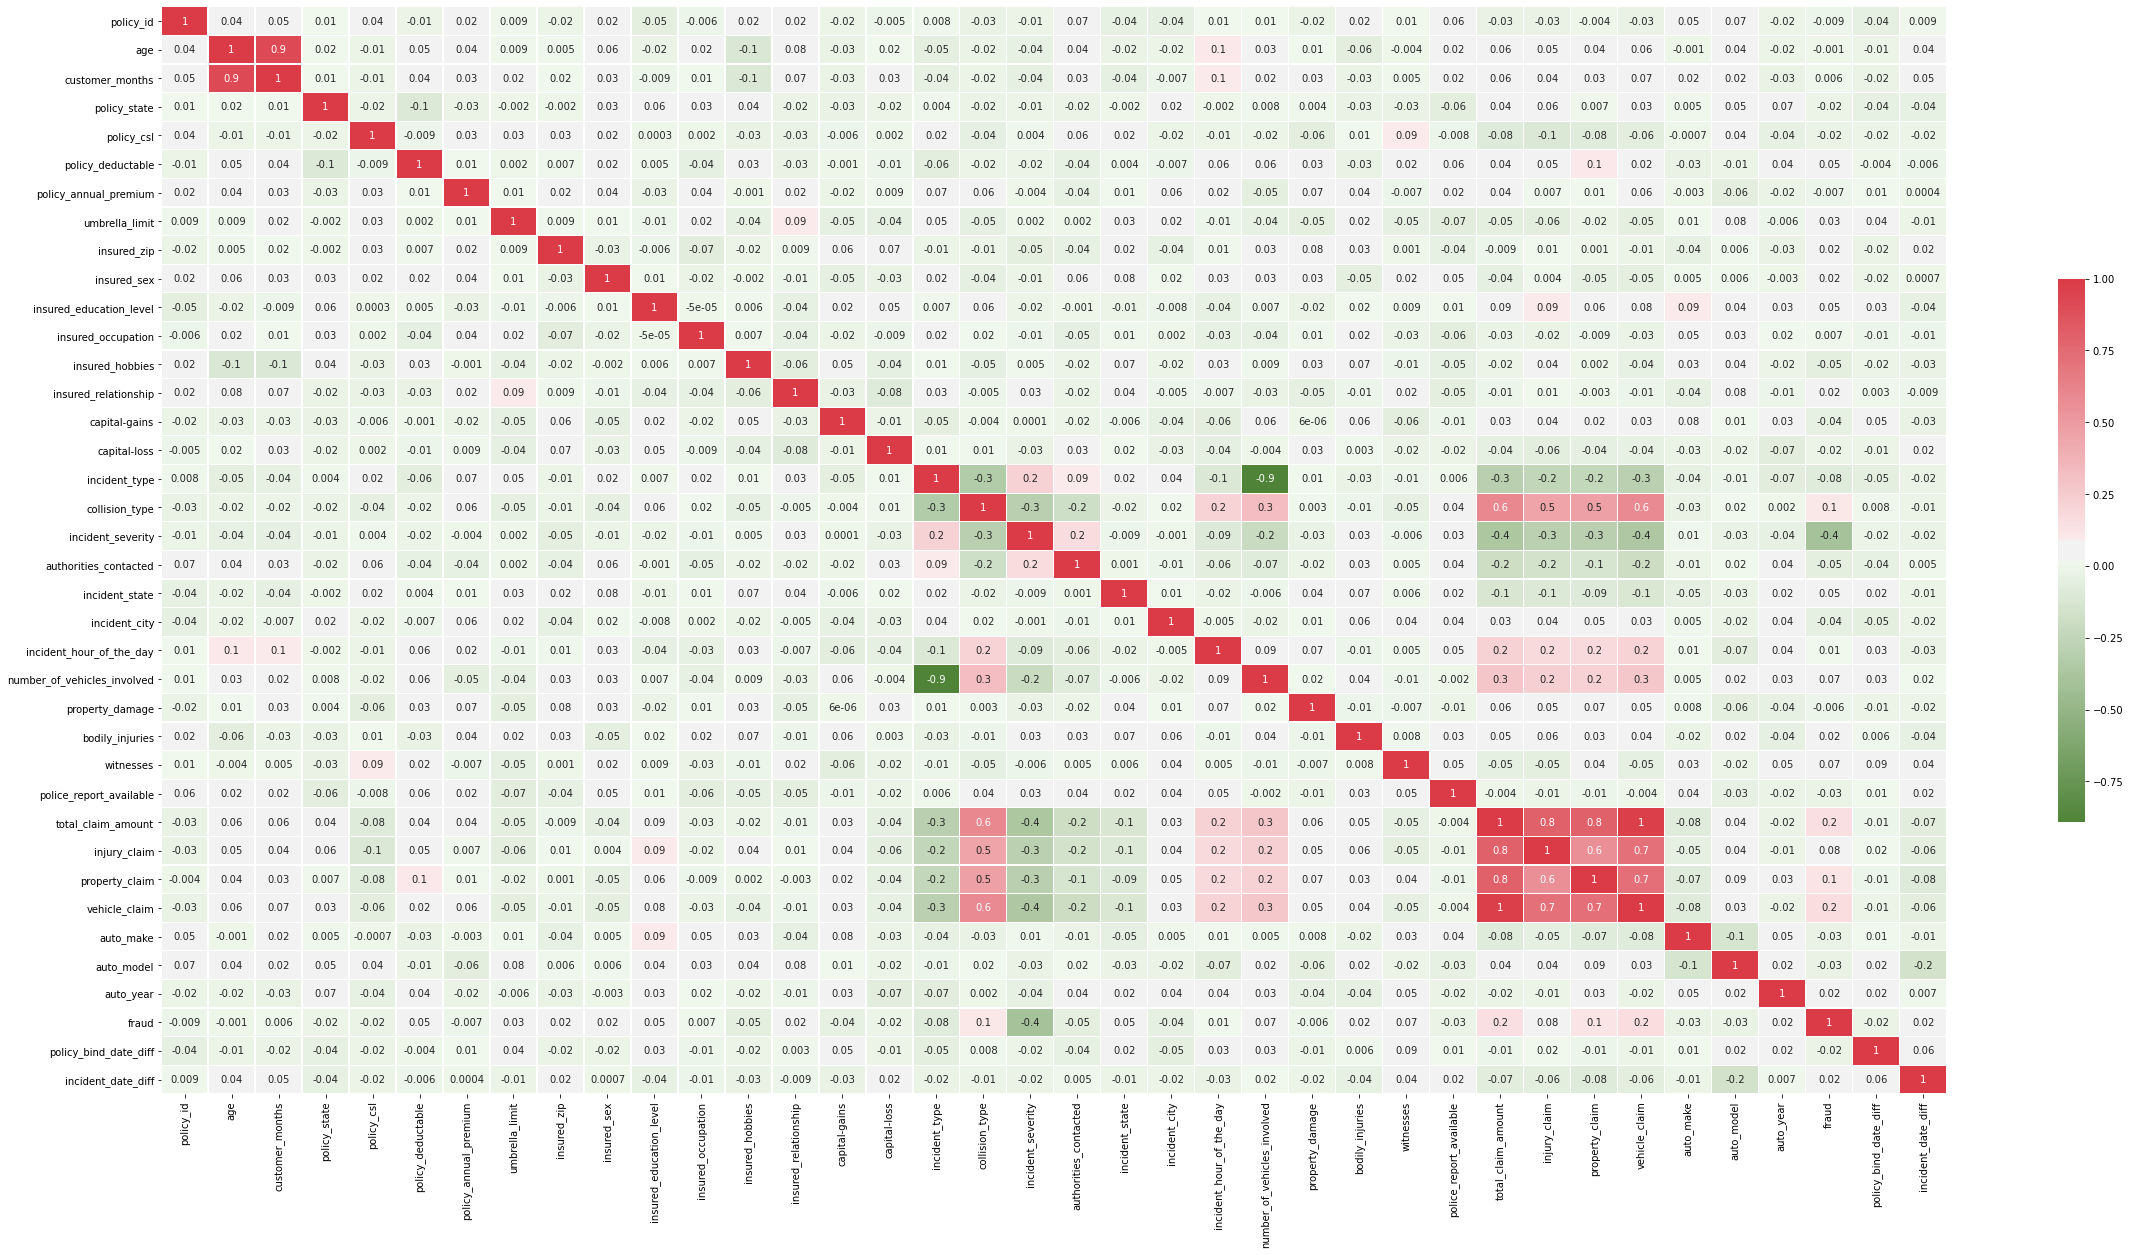

In [7]:
## 2.2 查看数据分布，查看数据分布是为了干什么，不懂，先跳过
## 2.3 查看相关性,生成热力图
cor = x_train.corr()
plt.figure(figsize=(40,20))
cmap = sns.diverging_palette(120, 10, as_cmap=True)
sns.heatmap(cor,cmap=cmap,annot = True,linewidth = 0.2,cbar_kws={"shrink": .5},linecolor = "white",fmt =".1g")
plt.show()

In [8]:
# 显示相关性高于0.6的变量
def getHighRelatedFeatureDf(corr_matrix, corr_threshold):
    highRelatedFeatureDf = pd.DataFrame(corr_matrix[corr_matrix > corr_threshold].stack().reset_index())
    highRelatedFeatureDf.rename({'level_0':'feature1','level_1':'feature2',0:'corr'},axis=1,inplace=True) # 更改列名
    highRelatedFeatureDf = highRelatedFeatureDf[highRelatedFeatureDf.feature1 != highRelatedFeatureDf.feature2] # 去除自己和自己
    highRelatedFeatureDf['feature_pair_key'] = highRelatedFeatureDf.loc[:,['feature1', 'feature2']].apply(lambda r:'#'.join(np.sort(r.values)), axis=1)
    # 将feature1和feature2名称连接在一起去重
    highRelatedFeatureDf.drop_duplicates(subset=['feature_pair_key'],inplace=True)
    highRelatedFeatureDf.drop(columns='feature_pair_key',inplace=True)
    return highRelatedFeatureDf

In [9]:
getHighRelatedFeatureDf(cor,0.6)

,feature1,feature2,corr
2,age,customer_months,0.92
31,total_claim_amount,injury_claim,0.80
32,total_claim_amount,property_claim,0.80
33,total_claim_amount,vehicle_claim,0.98
36,injury_claim,vehicle_claim,0.71
39,property_claim,vehicle_claim,0.72


In [10]:
## 去除相关性高的特征
for col in ['age','total_claim_amount','injury_claim','property_claim']:
    del x_train[col]
    del x_test[col]

In [21]:
## 3. 样本划分
# y_train = x_train['fraud']
# x_train = x_train.drop(columns=['policy_id', 'fraud'])

# x_train_01,x_train_02,y_train_01,y_train_02 = train_test_split(x_train,y_train,train_size=0.7)

x_train_01,x_train_02,y_train_01,y_train_02 = train_test_split(x_train,y_train,test_size=0.3,random_state=42)

# x_train_01, x_train_02 = train_test_split(x_train, test_size=0.3,random_state=42)  # 25% of remaining data as validation set
# y_train_01, y_train_02 = train_test_split(y_train, test_size=0.3, random_state=42)  # Split labels accordingly

In [22]:
## 4. 模型训练
# 4.1 GBDT模型
GBDT_param = {
    'loss': 'log_loss',
    'learning_rate': 0.1,
    'n_estimators': 30,
    'max_depth': 3,
    'min_samples_split': 300
}

GBDT_clf = GradientBoostingClassifier()  

# 4.2 决策树模型
tree_param = {
    'criterion': 'gini',
    'max_depth': 30,
    'min_impurity_decrease': 0.1,
    'min_samples_leaf': 2

}
Tree_clf = DecisionTreeClassifier(**tree_param)  #

# 4.3 xgboost模型
xgboost_param = {
    'learning_rate': 0.01,
    'reg_alpha': 0.,
    'max_depth': 3,
    'gamma': 0,
    'min_child_weight': 1

}



xgboost_clf = xgboost.XGBClassifier(**xgboost_param)

xgboost_clf.fit(x_train_01, y_train_01)
GBDT_clf.fit(x_train_01, y_train_01)
Tree_clf.fit(x_train_01, y_train_01)

DecisionTreeClassifier(max_depth=30, min_impurity_decrease=0.1,
                       min_samples_leaf=2)

In [23]:
# 5. 模型评估
# 5.1 K折交叉检验
K_model_list = [Tree_clf,GBDT_clf,xgboost_clf]
K_result = pd.DataFrame()
for i,val in enumerate(K_model_list):
    score = cross_validate(val,x_train_02,y_train_02,cv=6,scoring='accuracy')
    K_result.loc[i,'accuracy'] = score['test_score'].mean()
K_result.index = pd.Series(['Tree','GBDT','XGBoost'])
K_result

,accuracy
Tree,0.74
GBDT,0.78
XGBoost,0.81


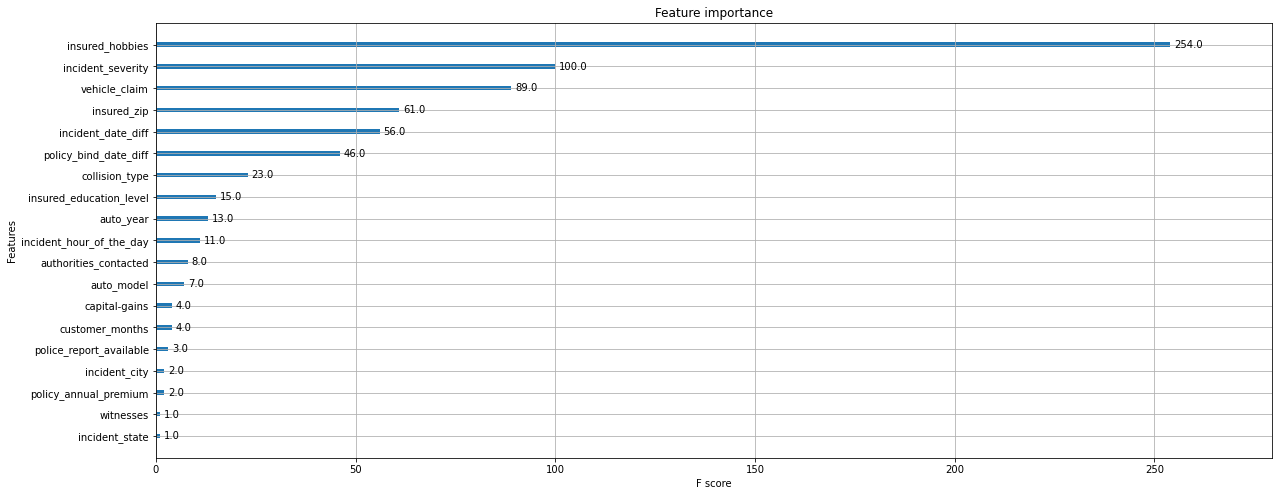

In [24]:
## 5.2 指标重要性排序
from xgboost import plot_importance
fig,ax = plt.subplots(figsize=(20,8))
plot_importance(xgboost_clf,ax=ax)

In [25]:
## 6. 结果输出
## 6.1 测试集测试

y_test_pred = xgboost_clf.predict_proba(x_test.drop(['policy_id'],axis=1))[:,1]
y_test_pred[y_test_pred>0.5] = 1
y_test_pred[y_test_pred<=0.5] = 0
y_test_pred

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1.,
       1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0.,
       0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 1.

In [26]:
## 6.1 结果提交
model_name = 'model_v20240430_1428'
result = pd.read_csv('./data/submission.csv')
result['fraud'] = y_test_pred
result.to_csv(f'./data/{model_name}.csv', index=False)